In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

**На вход в трансформер подаются уже закодированные слова - эмбеддинги + позиционные кодировки, чтобы модель учитывала порядок слов**


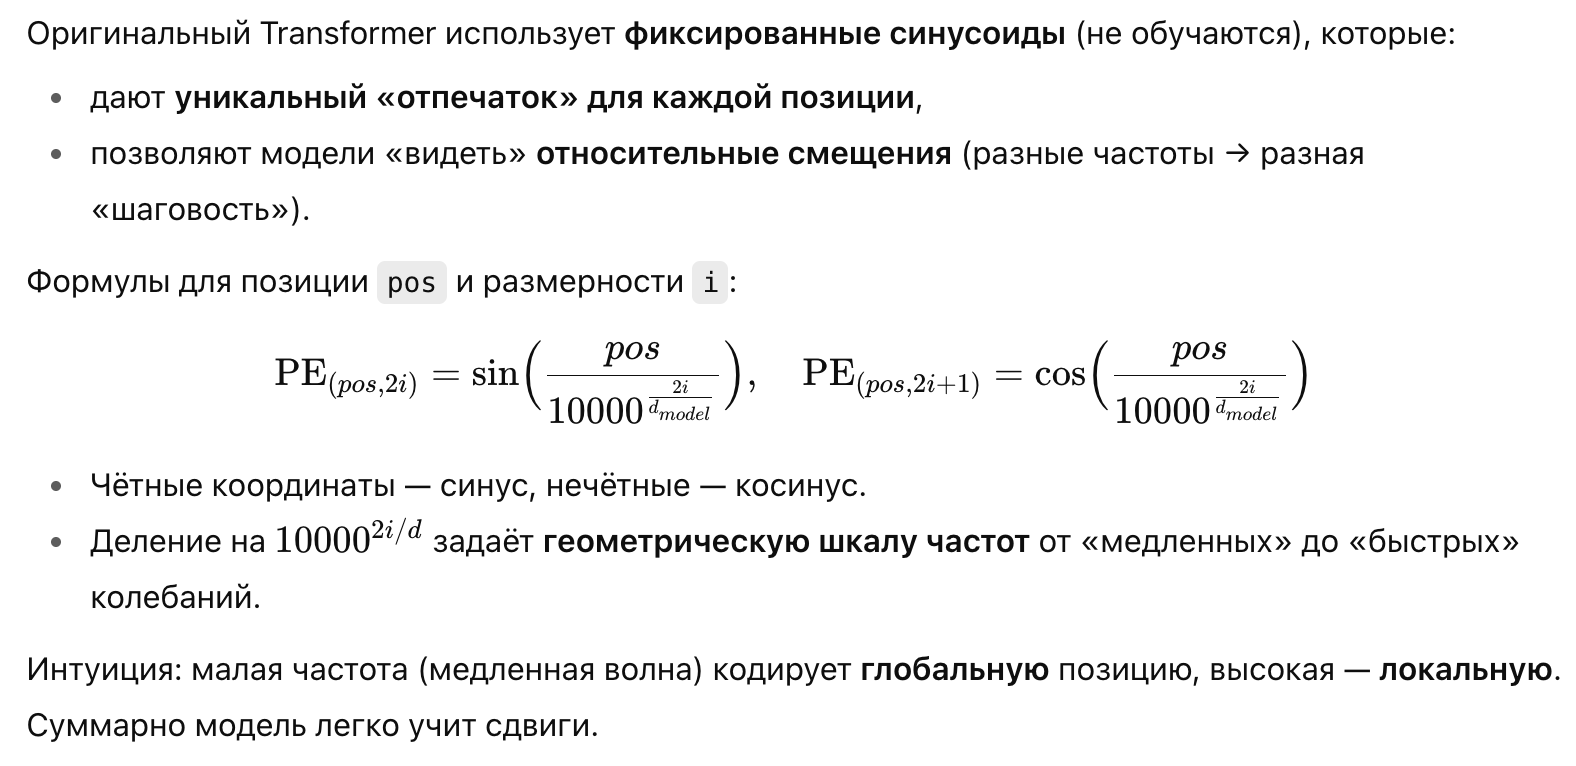

In [4]:
# Позиционное кодирование (синусоиды и косинусоиды) 
# почти как в оригинальной статье :) 
class PositionalEncoding(nn.Module):
    """
    d_model - размерность эмбеддинга
    max_len - максимум длины последовательности
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Создаем матрицу позиционных кодировок размера [max_len, d_model]
        # Каждая строка — это позиция pos (0…max_len−1), 
        # каждый столбец — «канал» (измерение) эмбеддинга 0…d_model−1.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Вектор позиций 0, 1, 2, …, max_len-1 → тензор формы [max_len]
        # unsqueeze(1) добавляет ось столбца → форма [max_len, 1].
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )# Формируем вектор «частот» для чётных каналов размерности [d_model/2]: индексы 2i, где i = 0, 1, 2, ...
        pe[:, 0::2] = torch.sin(position * div_term) # чётные каналы
        pe[:, 1::2] = torch.cos(position * div_term) # нечётные каналы
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch, seq_len, d_model]
        x = x + self.pe[:, :x.size(1)]
        return x

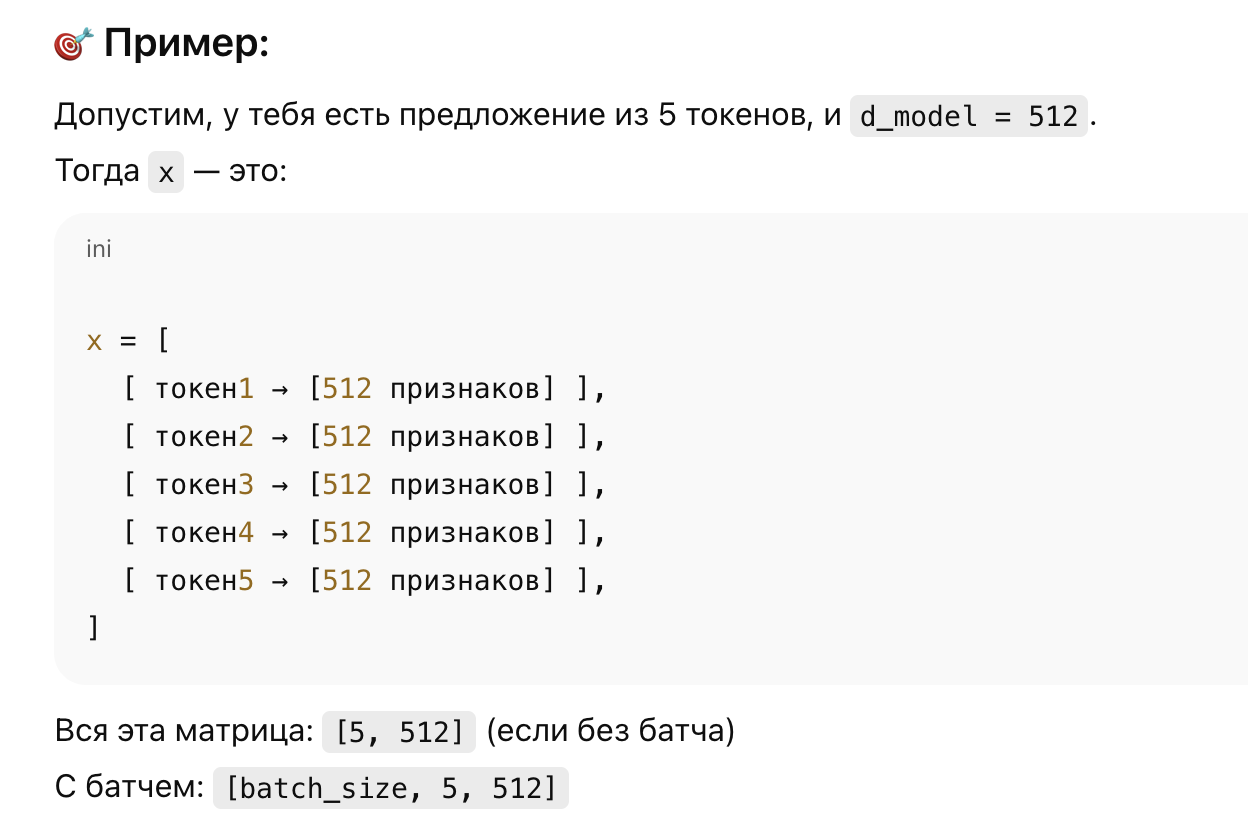

In [17]:
# ---- Multi-Head Attention ----

class MultiHeadAttention(nn.Module):
    """
    d_model — это размерность вектора признаков для каждого токена (или эмбеддинга).
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        # обучаемые матрицы
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask = None):
        batch_size = query.size(0)

        Q = self.W_q(query)
        # у нас вектор эмбеддинга один, это вектор «про всё сразу»: семантика, синтаксис, позиция, контекст...
        # мы хотим работать параллельно, делим наш вектор на несколько представлений
        Q_reshaped = Q.view(batch_size, -1, self.num_heads, self.d_k)
        # Чтобы можно было одновременно обрабатывать много attention-механизмов
        Q = Q_reshaped.transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Считаем Attention-score: [batch, heads, seq_len, seq_len]
        # и нормируем, если у нас матрицы слишком большой размерности
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim=-1)
        # и теперь умножаем на V, взвешиваем значения
        out = attention @ V

        # объединяем головы
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.fc(out)

In [6]:
# ---- Feed Forward ----
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff) # расширяем
        self.relu = nn.ReLU() # применяем нелинейность
        self.dropout = nn.Dropout(dropout) # случ зануляем нейроны 
        self.linear2 = nn.Linear(d_ff, d_model) # сужаем

    def forward(self, x):
        """
        x - тензор токенов, каждый - вектор длины d_model
        """
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [13]:
# ---- Encoder Layer ----
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feedforward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-Attention + Residual + Norm
        attention_out = self.attention(x, x, x, mask)
        x = x + self.dropout(attention_out)
        x = self.norm1(x)
        # Feed Forward + Residual + Norm
        feedforward_out = self.feedforward(x)
        x = x + self.dropout(feedforward_out)
        x = self.norm2(x)

        return x

In [14]:
# ---- Decoder Layer ----
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.cross_attention = MultiHeadAttention(d_model, num_heads)
        self.feedforward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        # Masked Self-Attention
        attention1 = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attention1))
        
        # Cross-Attention (Q=decoder, K,V=encoder)
        attention2 = self.cross_attention(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(attention2))

        # FeedForward
        feedforward_out = self.feedforward(x)
        x = self.norm3(x + self.dropout(feedforward_out))
        return x

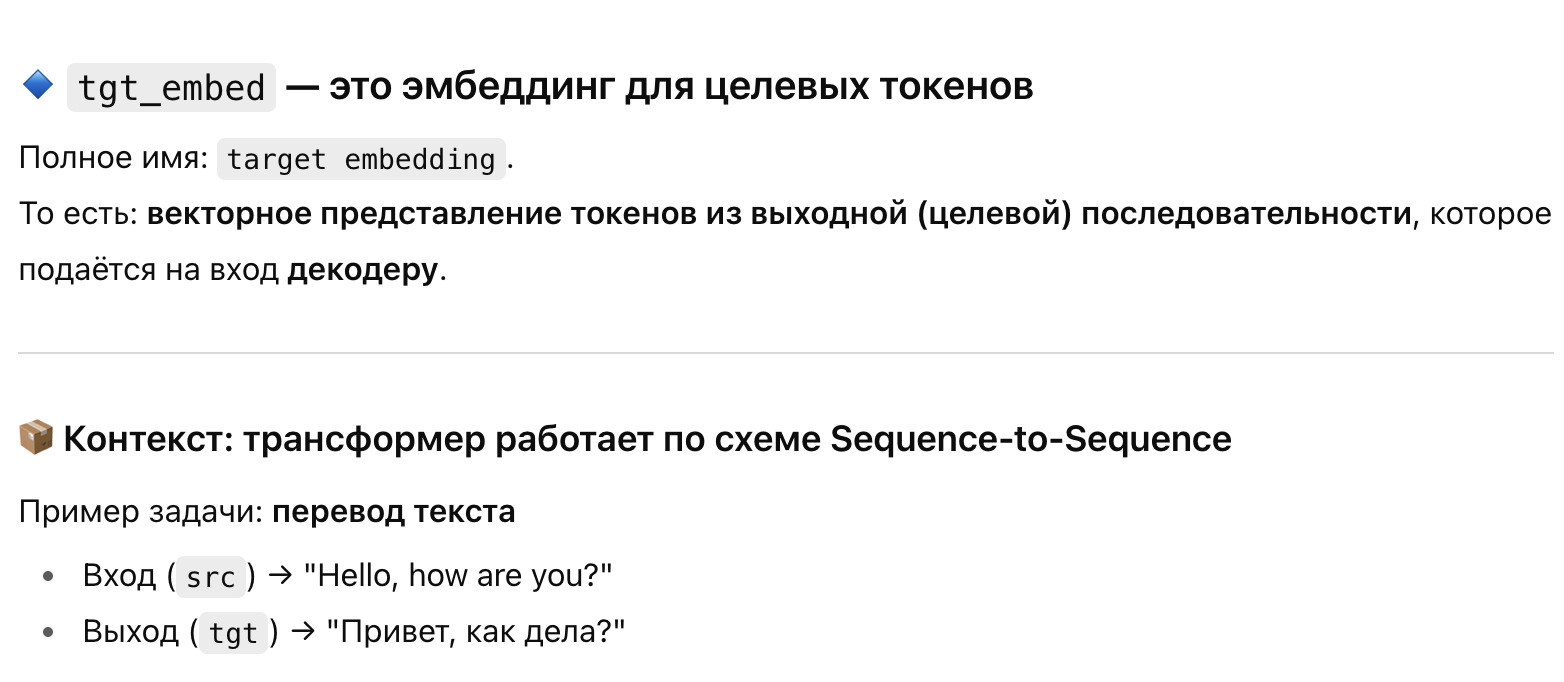

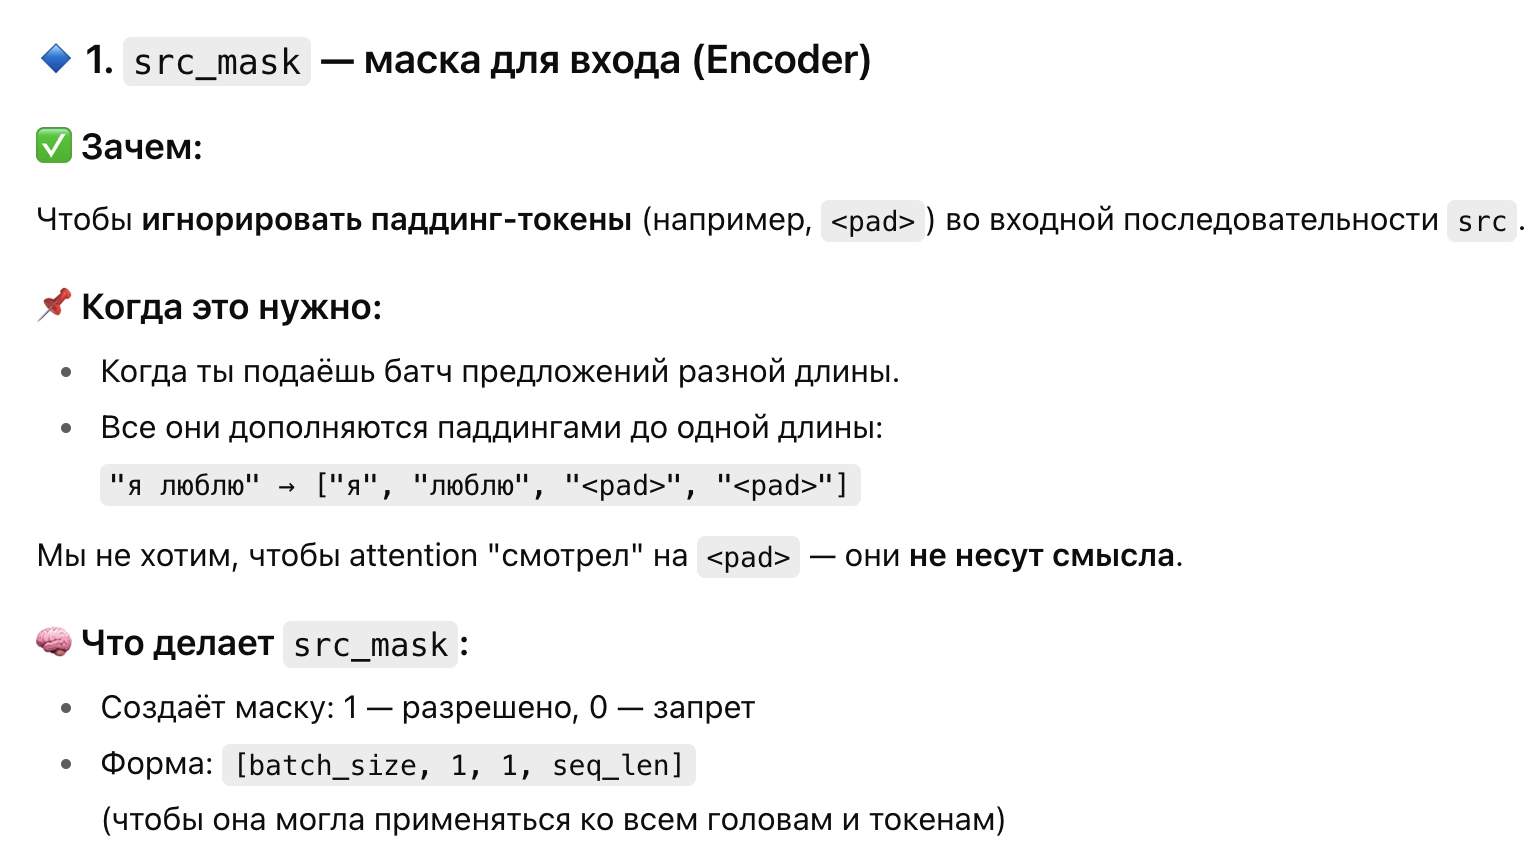
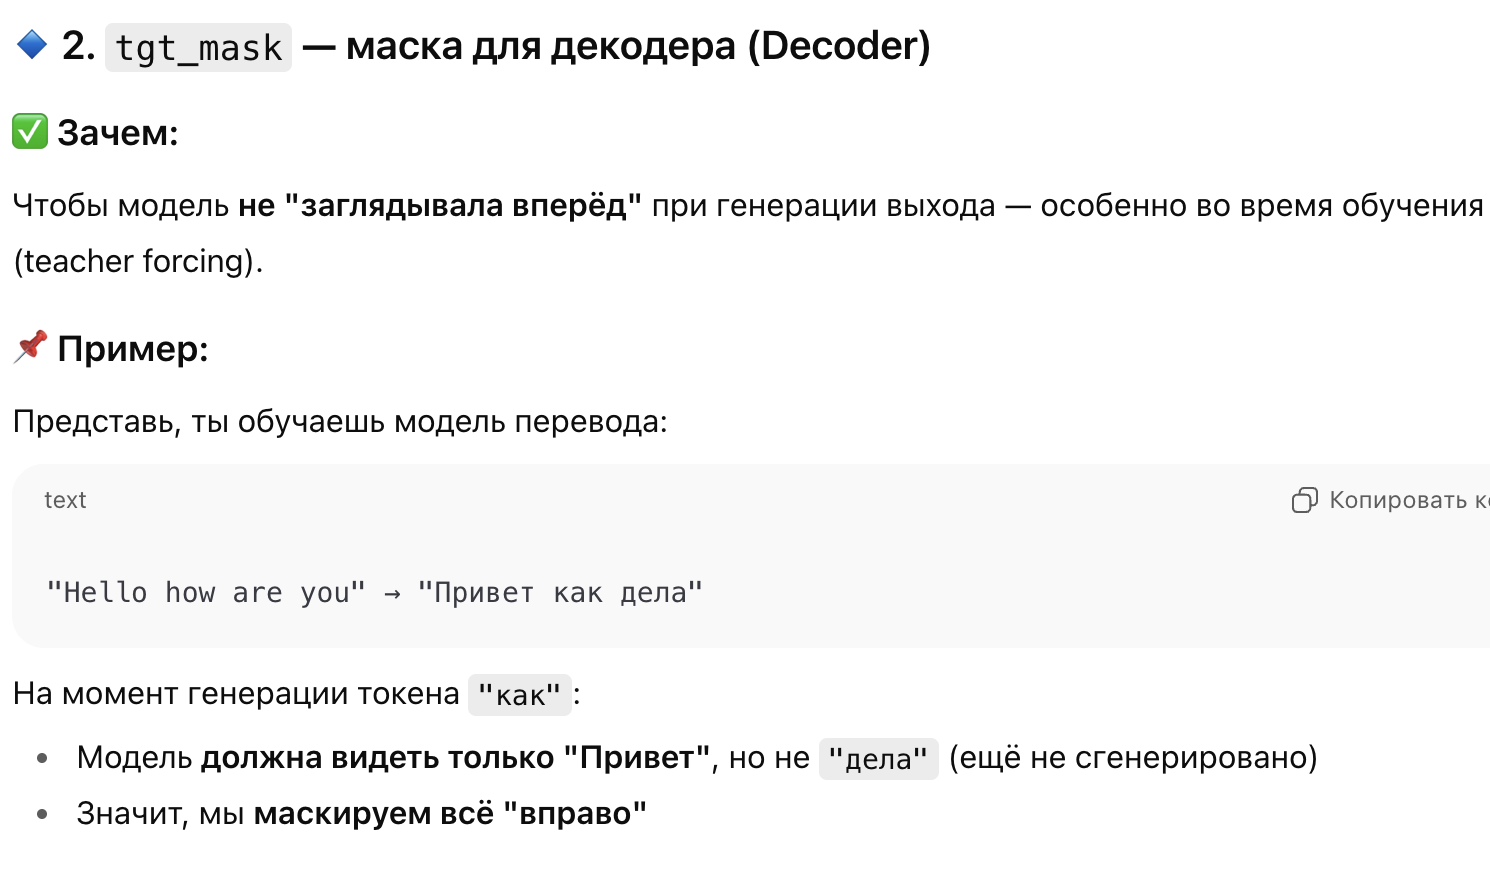

In [15]:
# ---- Полный Transformer ----

class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, num_heads = 8, num_layers=6, d_ff=2048, dropout=0.1, max_len=5000):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)

        # создаем энкодер как последовательность из num_layers слоев EncodeLayer
        self.encoding_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for i in range(num_layers)
        ])
        # создаем декодер как последовательность из num_layers слоев DecodeLayer
        self.decoding_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for i in range(num_layers)
        ])

        self.fc_out = nn.Linear(d_model, tgt_vocab)

    def make_src_mask(self, src):
        # Маска для паддингов (src: [batch, seq_len])
        return (src != 0).unsqueeze(1).unsqueeze(2)

    def make_tgt_mask(self, tgt):
        # Маска для декодера: запрещаем смотреть вперёд
        seq_len = tgt.size(1)
        mask = torch.tril(torch.ones((seq_len, seq_len), device=tgt.device)).bool()
        return mask.unsqueeze(0).unsqueeze(1)

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        # Encoder
        enc_out = self.pos_enc(self.src_embed(src))
        for layer in self.encoding_layers:
            encoding_out = layer(enc_out, src_mask)

        # Decoder
        dec_out = self.pos_enc(self.tgt_embed(tgt))
        for layer in self.decoding_layers:
            dec_out = layer(dec_out, enc_out, src_mask, tgt_mask)

        # Проекция в словарь
        out = self.fc_out(dec_out)
        return out
        

Протестим

In [18]:
# Словари по 100 токенов (условно)
model = Transformer(src_vocab=100, tgt_vocab=100, d_model=64, num_heads=4, num_layers=2)

src = torch.randint(1, 100, (2, 10))  # batch=2, seq_len=10
tgt = torch.randint(1, 100, (2, 9))   # decoder input

out = model(src, tgt)  # [batch, seq_len, vocab_size]
print(out.shape)  # должен быть torch.Size([2, 9, 100])


torch.Size([2, 9, 100])


2 - batch size — 2 входные пары (src, tgt)
9 - длина выходной последовательности (tgt)
100 - размер словаря tgt_vocab (логиты по каждому токену)

**То есть**:

Я подал 2 последовательности на вход (2 батча), и прошу предсказать по ним целевые токены длины 9.
Модель возвращает логиты по всем 100 токенам словаря на каждом шаге.